In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# County Data with fips county data for geolocation
County_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
C_df = pd.read_csv(County_url)
print(C_df.head())

         date     county       state     fips  cases  deaths
0  2020-01-21  Snohomish  Washington  53061.0      1       0
1  2020-01-22  Snohomish  Washington  53061.0      1       0
2  2020-01-23  Snohomish  Washington  53061.0      1       0
3  2020-01-24       Cook    Illinois  17031.0      1       0
4  2020-01-24  Snohomish  Washington  53061.0      1       0


In [3]:
df = C_df.loc[C_df['fips'] == 39113]
df

,date,county,state,fips,cases,deaths
4943,2020-03-19,Montgomery,Ohio,39113.0,1,0
5807,2020-03-20,Montgomery,Ohio,39113.0,1,0
6808,2020-03-21,Montgomery,Ohio,39113.0,1,0
7919,2020-03-22,Montgomery,Ohio,39113.0,5,0
9126,2020-03-23,Montgomery,Ohio,39113.0,7,0
10447,2020-03-24,Montgomery,Ohio,39113.0,10,0
11902,2020-03-25,Montgomery,Ohio,39113.0,14,0
13519,2020-03-26,Montgomery,Ohio,39113.0,14,0
15267,2020-03-27,Montgomery,Ohio,39113.0,19,0
17120,2020-03-28,Montgomery,Ohio,39113.0,20,0


In [4]:
df = df.loc[:,['date','cases','fips','deaths']]
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )

In [5]:
df

,date,cases,fips,deaths
4943,78,1,39113.0,0
5807,79,1,39113.0,0
6808,80,1,39113.0,0
7919,81,5,39113.0,0
9126,82,7,39113.0,0
10447,83,10,39113.0,0
11902,84,14,39113.0,0
13519,85,14,39113.0,0
15267,86,19,39113.0,0
17120,87,20,39113.0,0


In [6]:
# Calculate the general percentage of infection by dividing the number of new cases
# by the average census and multiplying by 100.
# For more specific rates, divide the number of new cases by total resident days and multiply by 1000,
# which gives you the number of infections per 1000 resident days.
# Montgomery county current population = 531,669

# New cases divided by population for infection rate
popu = 531669
new_cases = df.iloc[-1,1]
infection_rate = (new_cases/popu)*1000
print(infection_rate)
current_cases = df.iloc[-1,1]
current_date = df.iloc[-1,0]
# print("Current date delta: ",current_date,"Current cases: ",current_cases)

0.37241215869272043


In [7]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [8]:
a = infection_rate # Infection rate
b = df.iloc[-1,0] # df.date[-1:] # Current date num
c = df.iloc[-1,1] # df.cases[-1:] # Current case num
x = list(df.iloc[:,0]) # date list
y = list(df.iloc[:,1]) # case list
p0=[5,200,2000]
fit = curve_fit(logistic_model,x,y,p0,maxfev=50000)
fit
# print(infection_rate)
# print(b)
# print(c)
# print(x,len(x))
# print(y,len(y))


(array([  4.03499501,  97.45602888, 257.59029184]),
 array([[6.60938782e-02, 1.55255277e-01, 4.22615586e+00],
        [1.55255277e-01, 4.51001501e-01, 1.22271816e+01],
        [4.22615586e+00, 1.22271816e+01, 3.40974934e+02]]))

In [9]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
print(errors)

[0.2570872968005048, 0.6715664532521491, 18.465506599446872]


In [10]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

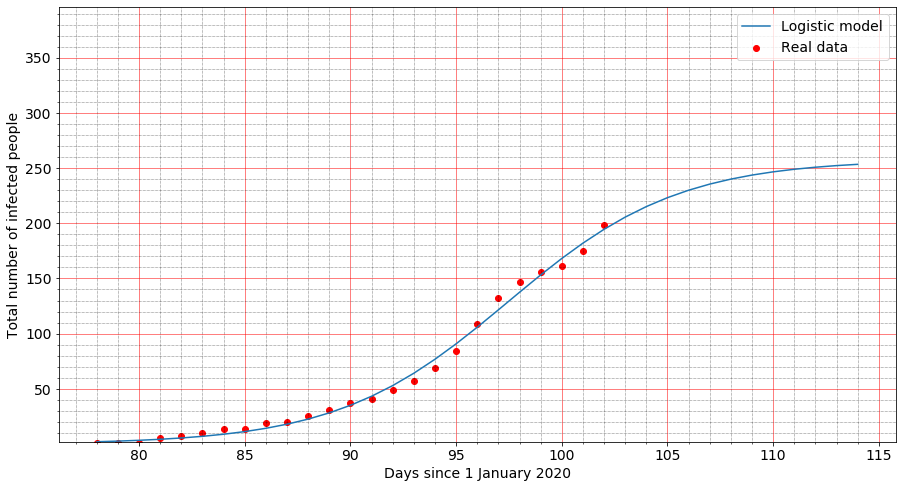

In [11]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [15, 8]

plt.rc('font', size=14)

# Real data
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )

plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*2.0,c*2.0))

# plt.grid()

# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')